# Logistic Regression on Amazon Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using three techniques: **<br>
**1. Average W2V. <br>**
**2. Average TFIDF-W2V. <br>**
**3. GloVe. <br>**

**Then perform following tasks under each technique:**<br>
**Task 1. Split train and test data in a ratio of 80:20.** <br>
**Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of λ.**<br>
**Task 3. Apply Logistic Regression using both L1 and L2 regularizations and report accuracy.**<br>
**Task 4. Use L1 regularization for different values of λ and report error and sparsity for each value of λ.**<br>
**Task 5. Check for multi-collinearity of features and find top-10 most important features**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

from gensim.models import Word2Vec
import gensim
import csv
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

C:\Users\GauravP\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [53]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [54]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [55]:
data.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
4      5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   
3                     0                       0  Positive  1350777600   
4                     0                       0  Positive  1342051200   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3            Great taffy  Great taffy at a great price.  There was a wid...   
4             Nice Taffy  I got a wild hair for taffy and ordered this f...   

                                       ProcessedText  
0  have bought sever the vital can dog food produ...  
1  product arriv label jumbo salt peanut the pean...  
2  this confect that has been around few centuri ...  
3  great taffi great price there was wide assort ...  
4  got wild hair for taffi and order this five po...

In [56]:
data.shape

(364171, 12)

In [57]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [58]:
def changingScores(score):
    if score == "Positive":
        return 1
    else:
        return -1

In [59]:
# changing score
# Positive = 1
# Negative = -1
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changingScores, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [60]:
data.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
4      5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0     -1  1346976000   
2                     1                       1      1  1219017600   
3                     0                       0      1  1350777600   
4                     0                       0      1  1342051200   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3            Great taffy  Great taffy at a great price.  There was a wid...   
4             Nice Taffy  I got a wild hair for taffy and ordered this f...   

                                       ProcessedText  
0  have bought sever the vital can dog food produ...  
1  product arriv label jumbo salt peanut the pean...  
2  this confect that has been around few centuri ...  
3  great taffi great price there was wide assort ...  
4  got wild hair for taffi and order this five po...

In [61]:
allPositiveReviews = data[(data["Score"] == 1)]

In [63]:
allPositiveReviews.shape

(307061, 12)

In [64]:
positiveReviews_2500 = allPositiveReviews[:2500]

In [65]:
positiveReviews_2500.shape

(2500, 12)

In [66]:
positiveReviews_2500.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
4      5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
5      6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
2                     1                       1      1  1219017600   
3                     0                       0      1  1350777600   
4                     0                       0      1  1342051200   
5                     0                       0      1  1340150400   

                                         Summary  \
0                          Good Quality Dog Food   
2                          "Delight" says it all   
3                                    Great taffy   
4                                     Nice Taffy   
5  Great!  Just as good as the expensive brands!   

                                                Text  \
0  I have bought several of the Vitality canned d...   
2  This is a confection that has been around a fe...   
3  Great taffy at a great price.  There was a wid...   
4  I got a wild hair for taffy and ordered this f...   
5  This saltwater taffy had great flavors and was...   

                                       ProcessedText  
0  have bought sever the vital can dog food produ...  
2  this confect that has been around few centuri ...  
3  great taffi great price there was wide assort ...  
4  got wild hair for taffi and order this five po...  
5  this saltwat taffi had great flavor and was ve...

In [68]:
allNegativeReviews = data[(data["Score"] == -1)]

In [69]:
allNegativeReviews.shape

(57110, 12)

In [70]:
negativeReviews_2500 = allNegativeReviews[:2500]

In [71]:
negativeReviews_2500.shape

(2500, 12)

In [72]:
negativeReviews_2500.head()

index  Id   ProductId          UserId     ProfileName  \
1       1   2  B00813GRG4  A1D87F6ZCVE5NK          dll pa   
11     12  13  B0009XLVG0   A327PCT23YH90              LT   
15     16  17  B001GVISJM  A3KLWF6WQ5BNYO  Erica Neathery   
25     26  27  B001GVISJM  A3RXAU2N8KV45G          lady21   
45     47  51  B001EO5QW8  A108P30XVUFKXY       Roberto A   

    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
1                      0                       0     -1  1346976000   
11                     1                       1     -1  1339545600   
15                     0                       0     -1  1348099200   
25                     0                       1     -1  1332633600   
45                     0                       7     -1  1203379200   

                                 Summary  \
1                      Not as Advertised   
11  My Cats Are Not Fans of the New Food   
15                            poor taste   
25                       Nasty No flavor   
45                         Don't like it   

                                                 Text  \
1   Product arrived labeled as Jumbo Salted Peanut...   
11  My cats have been happily eating Felidae Plati...   
15  I love eating them and they are good for watch...   
25  The candy is just red , No flavor . Just  plan...   
45  This oatmeal is not good. Its mushy, soft, I d...   

                                        ProcessedText  
1   product arriv label jumbo salt peanut the pean...  
11  cat have been happili eat felida platinum for ...  
15  love eat them and they are good for watch and ...  
25  the candi just red flavor just plan and chewi ...  
45  this oatmeal not good it mushi soft dont like ...

In [73]:
frames_5000 = [positiveReviews_2500, negativeReviews_2500]

In [74]:
FinalPositiveNegative = pd.concat(frames_5000)

In [75]:
FinalPositiveNegative.shape

(5000, 12)

In [76]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative_5000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [77]:
FinalSortedPositiveNegativeScore_5000 = FinalSortedPositiveNegative_5000["Score"]

In [78]:
FinalSortedPositiveNegative_5000.shape

(5000, 12)

In [79]:
FinalSortedPositiveNegativeScore_5000.shape

(5000,)

In [80]:
Data = FinalSortedPositiveNegative_5000

In [81]:
Data_Labels = FinalSortedPositiveNegativeScore_5000

In [82]:
print(Data.shape)
print(Data_Labels.shape)

(5000, 12)
(5000,)


In [83]:
Data.head()

index    Id   ProductId          UserId    ProfileName  \
772    1146  1245  B00002Z754  A29Z5PI9BW2PU3         Robbie   
771    1145  1244  B00002Z754  A3B8RCEI0FXFI6      B G Chase   
2418   3481  3783  B00016UX0K   AF1PV3DIC0XM7  Robert Ashton   
4417   5897  6386  B000084EK9  A1Z54EM24Y40LL             c2   
4408   5888  6376  B000084EKD  A1Z54EM24Y40LL             c2   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
772                      7                       7      1   961718400   
771                     10                      10      1   962236800   
2418                     1                       2      1  1081555200   
4417                     0                       0     -1  1090972800   
4408                     1                       1     -1  1090972800   

                             Summary  \
772                    Great Product   
771   WOW Make your own 'slickers' !   
2418               Classic Condiment   
4417              This stuff is bad!   
4408                  Needs improved   

                                                   Text  \
772   This was a really good idea and the final prod...   
771   I just received my shipment and could hardly w...   
2418  Mae Ploy Sweet Chili Sauce is becoming a stand...   
4417  I honestly have to say that I just won't buy t...   
4408  I haven't had a cat yet that liked this one.  ...   

                                          ProcessedText  
772   this was realli good idea and the final produc...  
771   just receiv shipment and could hard wait tri t...  
2418  mae ploy sweet chili sauc becom standard condi...  
4417  honest have say that just wont buy this variet...  
4408  havent had cat yet that like this one it just ...

## Average W2V

In [84]:
i = 0
listOfSentences = []
for sentence in Data["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [85]:
print(Data['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

this was realli good idea and the final product outstand use the decal car window and everybodi ask where bought the decal made two thumb


[['this', 'was', 'realli', 'good', 'idea', 'and', 'the', 'final', 'product', 'outstand', 'use', 'the', 'decal', 'car', 'window', 'and', 'everybodi', 'ask', 'where', 'bought', 'the', 'decal', 'made', 'two', 'thumb'], ['just', 'receiv', 'shipment', 'and', 'could', 'hard', 'wait', 'tri', 'this', 'product', 'love', 'which', 'what', 'call', 'them', 'instead', 'sticker', 'becaus', 'they', 'can', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'her', 'car', 'window', 'they', 'print', 'beauti', 'have', 'the', 'print', 'shop', 'program', 'go', 'have', 'lot', 'fun', 'with', 'this', 'product', 'becaus', 'there', 'are', 'window', 'everywher', 'and', 'other', 'surfac', 'like', 'screen', 'and', 'comput', 'monitor']]


<class 'list'>


In [86]:
w2vModel = gensim.models.Word2Vec(listOfSentences, size=400, min_count=5, workers=4)

In [87]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(400)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    sentenceVector /= TotalWordsPerSentence
    sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
5000
400


In [88]:
standardized_Avg_w2v = StandardScaler().fit_transform(sentenceAsW2V)
print(standardized_Avg_w2v.shape)
print(type(standardized_Avg_w2v))

(5000, 400)
<class 'numpy.ndarray'>


### Task 1. Split train and test data in a ratio of 80:20. 

In [95]:
train_AvgW2V, test_AvgW2V, train_labels_AvgW2V, test_labels_AvgW2V = train_test_split(standardized_Avg_w2v, FinalSortedPositiveNegativeScore_5000, test_size = 0.2, random_state = 0)

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of λ.

#### Grid Search

In [96]:
clf = LogisticRegression()

hyper_parameters = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 2, 4, 6, 8, 10**1, 50, 10**2, 500, 10**3]}]
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 5)
bestCV.fit(train_AvgW2V, train_labels_AvgW2V)

print(bestCV.best_estimator_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [97]:
best_parameter = bestCV.best_params_ 
best_parameter["C"]

1000

In [98]:
scoreData = bestCV.grid_scores_

In [99]:
scoreData

[mean: 0.74425, std: 0.02091, params: {'C': 0.001},
 mean: 0.76825, std: 0.01774, params: {'C': 0.01},
 mean: 0.78975, std: 0.01772, params: {'C': 0.1},
 mean: 0.80325, std: 0.01606, params: {'C': 1},
 mean: 0.81025, std: 0.01086, params: {'C': 2},
 mean: 0.81575, std: 0.01549, params: {'C': 4},
 mean: 0.81775, std: 0.01754, params: {'C': 6},
 mean: 0.82275, std: 0.01981, params: {'C': 8},
 mean: 0.82350, std: 0.01954, params: {'C': 10},
 mean: 0.83575, std: 0.01950, params: {'C': 50},
 mean: 0.83700, std: 0.01928, params: {'C': 100},
 mean: 0.83675, std: 0.01737, params: {'C': 500},
 mean: 0.83825, std: 0.01635, params: {'C': 1000}]

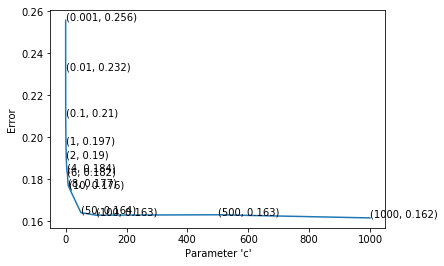

In [100]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["C"])
    
plot.plot(parameter, np.round(error, 4))
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plot.annotate(xy,xy)

plot.show()

#### Random Search

In [101]:
n = list(np.random.normal(loc=1000, scale=300, size = 500))  #taking 500 numbers which are distributed normally with mean = 1000
                                                            #and std-dev = 300

In [102]:
clf = LogisticRegression()

hyper_parameters2 = {'C': n}

bestCV_random = RandomizedSearchCV(clf, hyper_parameters2, scoring = "accuracy", cv = 3)

bestCV_random.fit(train_AvgW2V, train_labels_AvgW2V)
print(bestCV_random.best_estimator_)

LogisticRegression(C=584.2338438746062, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [103]:
best_random_parameter = bestCV_random.best_params_ 
best_random_parameter["C"]

584.2338438746062

In [104]:
scoreRandomData = bestCV_random.grid_scores_

In [105]:
scoreRandomData

[mean: 0.82975, std: 0.01597, params: {'C': 1268.184913640975},
 mean: 0.83550, std: 0.01679, params: {'C': 584.2338438746062},
 mean: 0.83125, std: 0.01646, params: {'C': 742.206958137426},
 mean: 0.83125, std: 0.01585, params: {'C': 1028.436950767072},
 mean: 0.83075, std: 0.01592, params: {'C': 769.9219219260337},
 mean: 0.83525, std: 0.01575, params: {'C': 533.6818785326748},
 mean: 0.83100, std: 0.01599, params: {'C': 764.631018708247},
 mean: 0.83175, std: 0.01679, params: {'C': 816.6946926002321},
 mean: 0.83150, std: 0.01613, params: {'C': 992.1699084299191},
 mean: 0.82950, std: 0.01440, params: {'C': 1614.448735785675}]

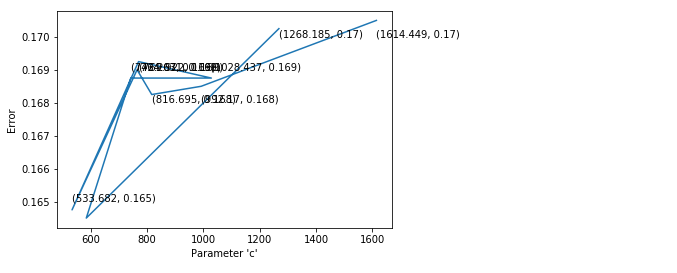

In [106]:
error2 = []
parameter2 = []
for i in range(len(scoreRandomData)):
    error2.append(1 - scoreRandomData[i][1])
    parameter2.append(scoreRandomData[i][0]["C"])  

plot.plot(parameter2, error2)
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error3 = []
for e in error2:
    error3.append(np.round(e,3))
    
parameter3 = []
for p in parameter2:
    parameter3.append(np.round(p,3))

for xy in zip(parameter3, error3):
        plot.annotate(xy,xy)

plot.show()

In [107]:
# We are taking our hyper-parameter λ as the average of best λ computed from gridSearchCV and RandomSearchCV
FinalHP = (best_parameter["C"] + best_random_parameter["C"]) / 2
FinalHP

792.1169219373031

### Task 3. Apply Logistic Regression using both L1 and L2 regularizations and report accuracy.

#### Implementing L2 Regularization

In [108]:
model = LogisticRegression(penalty="l2", C = FinalHP)

model.fit(train_AvgW2V, train_labels_AvgW2V)

prediction = model.predict(test_AvgW2V)

AccuracyScore = accuracy_score(test_labels_AvgW2V, prediction) * 100

print("Accuracy score on L2 regularization = "+str(AccuracyScore)+"%")

Accuracy score on L2 regularization = 83.6%


In [109]:
Precision = precision_score(test_labels_AvgW2V, prediction)
print("Precision Score on L2 regularization = "+str(Precision))

Precision Score on L2 regularization = 0.8366935483870968


In [110]:
Recall = recall_score(test_labels_AvgW2V, prediction)
print("Recall Score on L2 regularization = "+str(Recall))

Recall Score on L2 regularization = 0.8333333333333334


In [111]:
Confusion_Matrix = confusion_matrix(test_labels_AvgW2V, prediction)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[421  81]
 [ 83 415]]


In [116]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction).ravel()
tn, fp, fn, tp

(421, 81, 83, 415)

#### Implementing L1 Regularization

In [112]:
model2 = LogisticRegression(penalty="l1", C = FinalHP)

model2.fit(train_AvgW2V, train_labels_AvgW2V)

prediction2 = model2.predict(test_AvgW2V)

AccuracyScore2 = accuracy_score(test_labels_AvgW2V, prediction2) * 100

print("Accuracy score on L1 regularization = "+str(AccuracyScore2)+"%")

Accuracy score on L1 regularization = 83.2%


In [113]:
Precision2 = precision_score(test_labels_AvgW2V, prediction2)
print("Precision Score on L1 regularization = "+str(Precision2))

Precision Score on L1 regularization = 0.8423236514522822


In [114]:
Recall2 = recall_score(test_labels_AvgW2V, prediction2)
print("Recall Score on L1 regularization = "+str(Recall2))

Recall Score on L1 regularization = 0.8152610441767069


In [115]:
Confusion_Matrix2 = confusion_matrix(test_labels_AvgW2V, prediction2)
print("Confusion Matrix on L1 regularization \n"+str(Confusion_Matrix2))

Confusion Matrix on L1 regularization 
[[426  76]
 [ 92 406]]


In [117]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction2).ravel()
tn, fp, fn, tp

(426, 76, 92, 406)

### Task 4. Use L1 regularization for different values of λ and report error and sparsity for each value of λ.

In [118]:
model3 = LogisticRegression(penalty="l1", C = 10000)

model3.fit(train_AvgW2V, train_labels_AvgW2V)

accuracyScore_10000 = model3.score(test_AvgW2V, test_labels_AvgW2V)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.0001 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.0001 = "+str(error))

Number of non-zero for λ value of 0.0001 = 400
Error for λ value of 0.0001 = 0.16900000000000004


In [119]:
model3 = LogisticRegression(penalty="l1", C = 1000)

model3.fit(train_AvgW2V, train_labels_AvgW2V)

accuracyScore_1000 = model3.score(test_AvgW2V, test_labels_AvgW2V)

error = 1 - accuracyScore_1000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.001 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.001 = "+str(error))

Number of non-zero for λ value of 0.001 = 400
Error for λ value of 0.001 = 0.17100000000000004


In [120]:
model3 = LogisticRegression(penalty="l1", C = 10)

model3.fit(train_AvgW2V, train_labels_AvgW2V)

accuracyScore_10 = model3.score(test_AvgW2V, test_labels_AvgW2V)

error = 1 - accuracyScore_10

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.1 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.1 = "+str(error))

Number of non-zero for λ value of 0.1 = 230
Error for λ value of 0.1 = 0.18000000000000005


In [121]:
model3 = LogisticRegression(penalty="l1", C = 10**-3)

model3.fit(train_AvgW2V, train_labels_AvgW2V)

accuracyScore_0001 = model3.score(test_AvgW2V, test_labels_AvgW2V)

error = 1 - accuracyScore_0001

weightVector = model3.coef_

print("Number of non-zero for λ value of 1000 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 1000 = "+str(error))

Number of non-zero for λ value of 1000 = 0
Error for λ value of 1000 = 0.498


In [122]:
model3 = LogisticRegression(penalty="l1", C = 10**-4)

model3.fit(train_AvgW2V, train_labels_AvgW2V)

accuracyScore_00001 = model3.score(test_AvgW2V, test_labels_AvgW2V)

error = 1 - accuracyScore_00001

weightVector = model3.coef_

print("Number of non-zero for λ value of 10000 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 10000 = "+str(error))

Number of non-zero for λ value of 10000 = 0
Error for λ value of 10000 = 0.498


### Task 5. Check for multi-collinearity of features and find top-10 most important features

In [140]:
# computing weight vector prior to adding noise in out data
model4 = LogisticRegression(penalty="l2", C = FinalHP)

model4.fit(train_AvgW2V, train_labels_AvgW2V)

weightVector1 = model4.coef_

In [142]:
noise = np.random.normal(loc=0.1, scale=0.1) # generating random positive number from normal distribution
noise_matrix = np.full((4000, 400), noise) # generating matrix of size 4000 * 400 where every number in matrix is 'n' 
dataWithNoise_AvgW2V = noise_matrix + train_AvgW2V # adding noise to training data fro pertubation test

print(noise)
print(dataWithNoise_AvgW2V.shape)

0.08064478322530538
(4000, 400)


In [143]:
# computing weight vector after adding noise in out data
model5 = LogisticRegression(penalty="l2", C = FinalHP)

model5.fit(dataWithNoise_AvgW2V, train_labels_AvgW2V)

weightVector2 = model5.coef_

In [144]:
differenceInWeights = weightVector1 - weightVector2

In [147]:
differenceInWeights.ravel()

array([ 1.24805364e-01,  1.70932769e-01, -1.11871736e-02,  1.03912758e-01,
        7.93223365e-02,  4.18818609e-01,  1.36661723e-01,  4.56989891e-01,
       -3.92898222e-02,  1.98360903e-01, -9.05991926e-02,  1.49630554e-01,
        4.45303410e-01, -2.78539118e-01, -2.28059601e-01,  9.20603735e-02,
        5.06654285e-01,  2.77161689e-01,  3.67958794e-01, -2.30820079e-01,
        2.28275354e-01,  2.03324644e-01,  3.78095885e-01,  7.99650271e-01,
       -1.28208345e-01,  3.46592046e-01,  4.44813411e-01,  9.70867561e-02,
        2.07690249e-01,  2.95724366e-01, -3.50075373e-01,  1.00622917e+00,
        1.61358295e-01,  8.61132850e-02,  1.40308026e-01,  2.56285727e-01,
        4.15229139e-02,  6.16934756e-01,  5.63410977e-01,  1.85443428e-01,
       -1.09950435e-01,  1.06918044e+00,  3.31539367e-01,  8.17591979e-02,
        8.78324226e-01,  8.58061135e-02,  2.94267113e-01,  1.06538155e+00,
        1.20842287e+00,  2.76184956e-01,  4.25152321e-01,  4.43081384e-01,
       -5.81952172e-02,  

**Here, as you can see that the differnce in the weight vectors prior and after adding noise is high. It means that features are collinear, hence we cannot use weight vectors as feature importance.**
**Since word to vec generates vectors for words which are dependent on each other owing to their similarity of preserving sementic meaning between similar words. Therefore, features in word 2 vec are collinear**

## TFIDF-W2V

In [148]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [149]:
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [150]:
print(tfidf.shape)
print(type(tfidf))

(5000, 141225)
<class 'scipy.sparse.csr.csr_matrix'>


In [151]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

In [152]:
standardized_tfidf_w2v = StandardScaler().fit_transform(tfidf_w2v)
print(standardized_tfidf_w2v.shape)
print(type(standardized_tfidf_w2v))

(5000, 300)
<class 'numpy.ndarray'>


### Task 1. Split train and test data in a ratio of 80:20. 

In [154]:
train_tfidf_w2v, test_tfidf_w2v, train_labels_tfidf_w2v, test_labels_tfidf_w2v = train_test_split(standardized_tfidf_w2v, FinalSortedPositiveNegativeScore_5000, test_size = 0.2, random_state = 0)

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of λ.

#### Grid Search

In [158]:
clf = LogisticRegression()

hyper_parameters = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 2, 4, 6, 8, 10**1, 50, 10**2, 500, 10**3]}]
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 5)
bestCV.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

print(bestCV.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [159]:
best_parameter = bestCV.best_params_ 
best_parameter["C"]

100

In [160]:
scoreData = bestCV.grid_scores_

In [161]:
scoreData

[mean: 0.71625, std: 0.00749, params: {'C': 0.001},
 mean: 0.74875, std: 0.01448, params: {'C': 0.01},
 mean: 0.77125, std: 0.02277, params: {'C': 0.1},
 mean: 0.78325, std: 0.02076, params: {'C': 1},
 mean: 0.78925, std: 0.01894, params: {'C': 2},
 mean: 0.79425, std: 0.02060, params: {'C': 4},
 mean: 0.79900, std: 0.02077, params: {'C': 6},
 mean: 0.80050, std: 0.02104, params: {'C': 8},
 mean: 0.80300, std: 0.01889, params: {'C': 10},
 mean: 0.81525, std: 0.01951, params: {'C': 50},
 mean: 0.81825, std: 0.01816, params: {'C': 100},
 mean: 0.81600, std: 0.02139, params: {'C': 500},
 mean: 0.81200, std: 0.02279, params: {'C': 1000}]

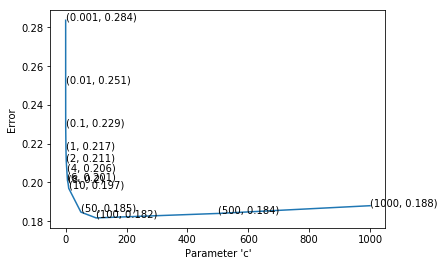

In [162]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["C"])
    
plot.plot(parameter, np.round(error, 4))
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plot.annotate(xy,xy)

plot.show()

#### Random Search

In [168]:
n = list(np.random.normal(loc=100, scale=40, size = 500))  #taking 500 numbers which are distributed normally with mean = 100
                                                            #and std-dev = 40

In [170]:
clf = LogisticRegression()

hyper_parameters2 = {'C': n}

bestCV_random = RandomizedSearchCV(clf, hyper_parameters2, scoring = "accuracy", cv = 3)

bestCV_random.fit(train_tfidf_w2v, train_labels_tfidf_w2v)
print(bestCV_random.best_estimator_)

LogisticRegression(C=107.56924891512601, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [171]:
best_random_parameter = bestCV_random.best_params_ 
best_random_parameter["C"]

107.56924891512601

In [172]:
scoreRandomData = bestCV_random.grid_scores_

In [173]:
scoreRandomData

[mean: 0.81475, std: 0.01267, params: {'C': 105.79602841658702},
 mean: 0.81500, std: 0.01234, params: {'C': 106.03462308100598},
 mean: 0.81525, std: 0.01239, params: {'C': 107.56924891512601},
 mean: 0.81475, std: 0.01352, params: {'C': 117.66038469974445},
 mean: 0.81450, std: 0.01239, params: {'C': 138.8575850139698},
 mean: 0.81125, std: 0.01322, params: {'C': 75.54013058206478},
 mean: 0.81175, std: 0.01303, params: {'C': 73.26089309251445},
 mean: 0.81525, std: 0.01384, params: {'C': 124.6782235005891},
 mean: 0.81450, std: 0.01218, params: {'C': 193.7661208459057},
 mean: 0.81450, std: 0.01299, params: {'C': 167.489215456119}]

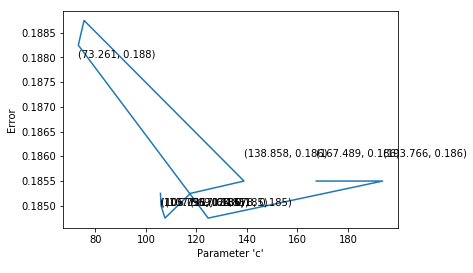

In [174]:
error2 = []
parameter2 = []
for i in range(len(scoreRandomData)):
    error2.append(1 - scoreRandomData[i][1])
    parameter2.append(scoreRandomData[i][0]["C"])  

plot.plot(parameter2, error2)
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error3 = []
for e in error2:
    error3.append(np.round(e,3))
    
parameter3 = []
for p in parameter2:
    parameter3.append(np.round(p,3))

for xy in zip(parameter3, error3):
        plot.annotate(xy,xy)

plot.show()

In [175]:
# We are taking our hyper-parameter λ as the average of best λ computed from gridSearchCV and RandomSearchCV
FinalHP = (best_parameter["C"] + best_random_parameter["C"]) / 2
FinalHP

103.78462445756301

### Task 3. Apply Logistic Regression using both L1 and L2 regularizations and report accuracy.

#### Implementing L2 Regularization

In [176]:
model = LogisticRegression(penalty="l2", C = FinalHP)

model.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

prediction = model.predict(test_tfidf_w2v)

AccuracyScore = accuracy_score(test_labels_tfidf_w2v, prediction) * 100

print("Accuracy score on L2 regularization = "+str(AccuracyScore)+"%")

Accuracy score on L2 regularization = 80.7%


In [179]:
Precision = precision_score(test_labels_tfidf_w2v, prediction)
print("Precision Score on L2 regularization = "+str(Precision))

Precision Score on L2 regularization = 0.8157349896480331


In [188]:
Recall = recall_score(test_labels_tfidf_w2v, prediction)
print("Recall Score on L2 regularization = "+str(Recall))

Recall Score on L2 regularization = 0.7911646586345381


In [189]:
Confusion_Matrix = confusion_matrix(test_labels_tfidf_w2v, prediction)
print("Confusion Matrix on L2 regularization \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization 
[[413  89]
 [104 394]]


In [187]:
tn, fp, fn, tp = confusion_matrix(test_labels_tfidf_w2v, prediction).ravel()
tn, fp, fn, tp

(413, 89, 104, 394)

#### Implementing L1 Regularization

In [191]:
model2 = LogisticRegression(penalty="l1", C = FinalHP)

model2.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

prediction2 = model2.predict(test_tfidf_w2v)

AccuracyScore2 = accuracy_score(test_labels_tfidf_w2v, prediction2) * 100

print("Accuracy score on L1 regularization = "+str(AccuracyScore2)+"%")

Accuracy score on L1 regularization = 80.7%


In [192]:
Precision2 = precision_score(test_labels_tfidf_w2v, prediction2)
print("Precision Score on L1 regularization = "+str(Precision2))

Precision Score on L1 regularization = 0.8144329896907216


In [193]:
Recall2 = recall_score(test_labels_tfidf_w2v, prediction2)
print("Precision Score on L1 regularization = "+str(Precision2))

Precision Score on L1 regularization = 0.8144329896907216


In [194]:
Confusion_Matrix2 = confusion_matrix(test_labels_tfidf_w2v, prediction2)
print("Confusion Matrix on L1 regularization \n"+str(Confusion_Matrix2))

Confusion Matrix on L1 regularization 
[[412  90]
 [103 395]]


In [195]:
tn, fp, fn, tp = confusion_matrix(test_labels_tfidf_w2v, prediction2).ravel()
tn, fp, fn, tp

(412, 90, 103, 395)

### Task 4. Use L1 regularization for different values of λ and report error and sparsity for each value of λ.

In [196]:
model3 = LogisticRegression(penalty="l1", C = 10000)

model3.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

accuracyScore_10000 = model3.score(test_tfidf_w2v, test_labels_tfidf_w2v)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.0001 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.0001 = "+str(error))

Number of non-zero for λ value of 0.0001 = 300
Error for λ value of 0.0001 = 0.18799999999999994


In [197]:
model3 = LogisticRegression(penalty="l1", C = 100)

model3.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

accuracyScore_10000 = model3.score(test_tfidf_w2v, test_labels_tfidf_w2v)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.01 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.01 = "+str(error))

Number of non-zero for λ value of 0.0001 = 292
Error for λ value of 0.01 = 0.19099999999999995


In [198]:
model3 = LogisticRegression(penalty="l1", C = 1)

model3.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

accuracyScore_10000 = model3.score(test_tfidf_w2v, test_labels_tfidf_w2v)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 1 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 1 = "+str(error))

Number of non-zero for λ value of 0.0001 = 85
Error for λ value of 1 = 0.21799999999999997


In [199]:
model3 = LogisticRegression(penalty="l1", C = 10**-3)

model3.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

accuracyScore_10000 = model3.score(test_tfidf_w2v, test_labels_tfidf_w2v)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 1000 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 1000 = "+str(error))

Number of non-zero for λ value of 0.0001 = 0
Error for λ value of 1000 = 0.498


### Task 5. Check for multi-collinearity of features and find top-10 most important features

In [200]:
# computing weight vector prior to adding noise in out data
model4 = LogisticRegression(penalty="l2", C = FinalHP)

model4.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

weightVector1 = model4.coef_

In [202]:
noise = np.random.normal(loc=0.1, scale=0.1) # generating random positive number from normal distribution
noise_matrix = np.full((4000, 300), noise) # generating matrix of size 4000 * 300 where every number in matrix is 'noise' 
dataWithNoise_tfidf_AvgW2V = noise_matrix + train_tfidf_w2v # adding noise to training data fro pertubation test

print(noise)
print(dataWithNoise_tfidf_AvgW2V.shape)

0.02300070878465929
(4000, 300)


In [203]:
# computing weight vector after adding noise in out data
model5 = LogisticRegression(penalty="l2", C = FinalHP)

model5.fit(dataWithNoise_tfidf_AvgW2V, train_labels_tfidf_w2v)

weightVector2 = model5.coef_

In [204]:
differenceWeights = weightVector1 - weightVector2
differenceWeights.ravel()

array([-1.29288568e-02,  7.05277795e-03, -1.42343271e-03,  7.95322385e-03,
       -1.16889928e-02,  5.90871933e-03, -6.26136071e-03, -9.31689173e-03,
        1.33540254e-03, -5.96326251e-03,  6.90715865e-03, -3.68980884e-03,
        4.37822680e-02,  1.71258714e-02,  1.63797423e-02,  9.53680248e-03,
        2.97579528e-02,  9.21537063e-03,  8.74318400e-04,  2.27536772e-02,
        1.24565633e-02,  6.22320722e-03,  8.98027940e-03,  3.39631451e-02,
       -8.69922080e-03, -9.38652612e-03,  7.88057618e-03, -1.80001347e-02,
        9.52894852e-03,  1.67691780e-03, -2.23035889e-02,  4.44436800e-02,
        1.04282626e-02,  1.67814503e-02,  2.65462036e-02,  2.49449828e-02,
        7.46989681e-03,  1.46980704e-02,  3.44653723e-02,  1.17297600e-02,
       -3.59700228e-03,  1.89764839e-02, -7.86729323e-03, -4.28927479e-03,
        1.27985915e-02,  1.54100148e-02,  1.46615161e-02,  2.50155434e-02,
        4.39080479e-02, -6.89995646e-03,  7.89254100e-04,  1.89435706e-02,
        1.37793028e-02,  

**Here, as you can see that the differnce in the weight vectors prior and after adding noise is high. It means that features are collinear, hence we cannot use weight vectors as feature importance. Since word to vec generates vectors for words which are dependent on each other owing to their similarity of preserving sementic meaning between similar words. Therefore, features in word 2 vec are collinear**

## GloVe

In [205]:
def cleanhtml(sentence): #function to clean htmltags
    cleanr = re.compile("<.*?>")
    cleantext = re.sub(cleanr, " ", sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [206]:
#removing HTML tags and punctuation from our text

i = 0
final_string = []
s = ""
for sentence in data["Text"].values:
    filteredSentence = []
    EachReviewText = ""
    sentenceHTMLCleaned = cleanhtml(sentence)
    for eachWord in sentenceHTMLCleaned.split():
        for sentencePunctCleaned in cleanpunc(eachWord).split():
            if((sentencePunctCleaned.isalpha()) & (len(sentencePunctCleaned)>2)):
                sentenceLower = sentencePunctCleaned.lower()
                filteredSentence.append(sentenceLower)
                     
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [207]:
data["ProcessedText2"] = final_string

In [208]:
data.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
4      5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0     -1  1346976000   
2                     1                       1      1  1219017600   
3                     0                       0      1  1350777600   
4                     0                       0      1  1342051200   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3            Great taffy  Great taffy at a great price.  There was a wid...   
4             Nice Taffy  I got a wild hair for taffy and ordered this f...   

                                       ProcessedText  \
0  have bought sever the vital can dog food produ...   
1  product arriv label jumbo salt peanut the pean...   
2  this confect that has been around few centuri ...   
3  great taffi great price there was wide assort ...   
4  got wild hair for taffi and order this five po...   

                                      ProcessedText2  
0  have bought several the vitality canned dog fo...  
1  product arrived labeled jumbo salted peanuts t...  
2  this confection that has been around few centu...  
3  great taffy great price there was wide assortm...  
4  got wild hair for taffy and ordered this five ...

In [209]:
allPositiveReviews2 = data[(data["Score"] == 1)]

In [210]:
allPositiveReviews2.shape

(307061, 13)

In [211]:
positiveReviews2_500 = allPositiveReviews2[:500]

In [212]:
positiveReviews2_500.shape

(500, 13)

In [213]:
positiveReviews2_500.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
4      5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
5      6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
2                     1                       1      1  1219017600   
3                     0                       0      1  1350777600   
4                     0                       0      1  1342051200   
5                     0                       0      1  1340150400   

                                         Summary  \
0                          Good Quality Dog Food   
2                          "Delight" says it all   
3                                    Great taffy   
4                                     Nice Taffy   
5  Great!  Just as good as the expensive brands!   

                                                Text  \
0  I have bought several of the Vitality canned d...   
2  This is a confection that has been around a fe...   
3  Great taffy at a great price.  There was a wid...   
4  I got a wild hair for taffy and ordered this f...   
5  This saltwater taffy had great flavors and was...   

                                       ProcessedText  \
0  have bought sever the vital can dog food produ...   
2  this confect that has been around few centuri ...   
3  great taffi great price there was wide assort ...   
4  got wild hair for taffi and order this five po...   
5  this saltwat taffi had great flavor and was ve...   

                                      ProcessedText2  
0  have bought several the vitality canned dog fo...  
2  this confection that has been around few centu...  
3  great taffy great price there was wide assortm...  
4  got wild hair for taffy and ordered this five ...  
5  this saltwater taffy had great flavors and was...

In [214]:
allNegativeReviews2 = data[(data["Score"] == -1)]

In [215]:
allNegativeReviews2.shape

(57110, 13)

In [216]:
negativeReviews2_500 = allNegativeReviews2[:500]

In [217]:
negativeReviews2_500.shape

(500, 13)

In [218]:
negativeReviews2_500.head()

index  Id   ProductId          UserId     ProfileName  \
1       1   2  B00813GRG4  A1D87F6ZCVE5NK          dll pa   
11     12  13  B0009XLVG0   A327PCT23YH90              LT   
15     16  17  B001GVISJM  A3KLWF6WQ5BNYO  Erica Neathery   
25     26  27  B001GVISJM  A3RXAU2N8KV45G          lady21   
45     47  51  B001EO5QW8  A108P30XVUFKXY       Roberto A   

    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
1                      0                       0     -1  1346976000   
11                     1                       1     -1  1339545600   
15                     0                       0     -1  1348099200   
25                     0                       1     -1  1332633600   
45                     0                       7     -1  1203379200   

                                 Summary  \
1                      Not as Advertised   
11  My Cats Are Not Fans of the New Food   
15                            poor taste   
25                       Nasty No flavor   
45                         Don't like it   

                                                 Text  \
1   Product arrived labeled as Jumbo Salted Peanut...   
11  My cats have been happily eating Felidae Plati...   
15  I love eating them and they are good for watch...   
25  The candy is just red , No flavor . Just  plan...   
45  This oatmeal is not good. Its mushy, soft, I d...   

                                        ProcessedText  \
1   product arriv label jumbo salt peanut the pean...   
11  cat have been happili eat felida platinum for ...   
15  love eat them and they are good for watch and ...   
25  the candi just red flavor just plan and chewi ...   
45  this oatmeal not good it mushi soft dont like ...   

                                       ProcessedText2  
1   product arrived labeled jumbo salted peanuts t...  
11  cats have been happily eating felidae platinum...  
15  love eating them and they are good for watchin...  
25  the candy just red flavor just plan and chewy ...  
45  this oatmeal not good its mushy soft dont like...

In [219]:
frames2_1000 = [positiveReviews2_500, negativeReviews2_500]

In [220]:
FinalPositiveNegative2 = pd.concat(frames2_1000)

In [221]:
FinalPositiveNegative2.shape

(1000, 13)

In [222]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative2_1000 = FinalPositiveNegative2.sort_values('Time', axis=0, ascending=True, inplace=False)

In [223]:
FinalSortedPositiveNegativeScore2_1000 = FinalSortedPositiveNegative2_1000["Score"]

In [224]:
FinalSortedPositiveNegative2_1000.shape

(1000, 13)

In [225]:
FinalSortedPositiveNegativeScore2_1000.shape

(1000,)

In [226]:
Data2 = FinalSortedPositiveNegative2_1000

In [227]:
Data2_Labels = FinalSortedPositiveNegativeScore2_1000

In [228]:
print(Data2.shape)
print(Data2_Labels.shape)

(1000, 13)
(1000,)


In [229]:
Data2.head()

index    Id   ProductId          UserId  \
9        10    11  B0001PB9FE  A3HDKO7OW0QNK4   
1653   2106  2296  B0001VWE02   AQM74O8Z4FMS0   
2558   3667  3984  B0005ZHWXI  A26HFSVLAGULIM   
1341   1779  1935  B000F4EU52  A2PNOU7NXB1JE4   
2307   3362  3661  B000FDKQC4  A1PNP10DP0M7V1   

                                        ProfileName  HelpfulnessNumerator  \
9                                      Canadian Fan                     1   
1653                                       Sunshine                     0   
2558  Heather L. Parisi "Robert and Heather Parisi"                     0   
1341                                 Peggy "pab920"                    14   
2307            D. Chamberlain "dchamberlain072002"                     7   

      HelpfulnessDenominator  Score        Time  \
9                          1      1  1107820800   
1653                       0     -1  1127606400   
2558                       1     -1  1131235200   
1341                      17     -1  1153008000   
2307                       8     -1  1156377600   

                                                Summary  \
9                       The Best Hot Sauce in the World   
1653                                     Below standard   
2558  ADD SKIM MILK - BANANA - BLUEBERRIES  -  WHEAT...   
1341                             Inside of can corroded   
2307                                      A Bitter Pill   

                                                   Text  \
9     I don't know if it's the cactus or the tequila...   
1653  Too much of the white pith on this orange peel...   
2558  SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEA...   
1341  After I enptied the can, I noticed it was blac...   
2307  I have to say that I really wanted to like the...   

                                          ProcessedText  \
9     dont know it the cactus the tequila just the u...   
1653  too much the white pith this orang peel make t...   
2558  someth eat your starv but pleas give real food...   
1341  after enpti the can notic was black area the t...   
2307  have say that realli want like these muffin bu...   

                                         ProcessedText2  
9     dont know its the cactus the tequila just the ...  
1653  too much the white pith this orange peel makin...  
2558  something eat youre starving but please give r...  
1341  after enptied the can noticed was black area t...  
2307  have say that really wanted like these muffins...

In [230]:
i = 0
listOfSentences2 = []
for sentence in Data2["ProcessedText2"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences2.append(subSentence)

In [231]:
print(Data2['ProcessedText2'].values[0])
print("\n")
print(listOfSentences2[0:2])
print("\n")
print(type(listOfSentences2))
print("\n")
print(len(listOfSentences2))

dont know its the cactus the tequila just the unique combination ingredients but the flavour this hot sauce makes one kind picked bottle once trip were and brought back home with and were totally blown away when realized that simply couldnt find anywhere our city were bummed now because the magic the internet have case the sauce and are ecstatic because you love hot sauce mean really love hot sauce but dont want sauce that tastelessly burns your throat grab bottle tequila picante gourmet inclan just realize that once you taste you will never want use any other sauce thank you for the personal incredible service


[['dont', 'know', 'its', 'the', 'cactus', 'the', 'tequila', 'just', 'the', 'unique', 'combination', 'ingredients', 'but', 'the', 'flavour', 'this', 'hot', 'sauce', 'makes', 'one', 'kind', 'picked', 'bottle', 'once', 'trip', 'were', 'and', 'brought', 'back', 'home', 'with', 'and', 'were', 'totally', 'blown', 'away', 'when', 'realized', 'that', 'simply', 'couldnt', 'find', 'anyw

In [11]:
#loading pre-trained GloVe vectors
words = pd.read_table("glove.6B.100d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE) 

# Here, We have downloaded pre-trained Glove vectors. You just have to type "Glove word vectors" on google then click on 
# "https://nlp.stanford.edu/projects/glove/" link. Then you can download pre-trained word-vectors. Zip file will be 
# downloaded, you just have to extract it then load the txt file from extracted folder into ipython notebook using pandas,
# just like we have done above.

In [233]:
def check(word):
    if (words.index == word).any():
        return 1
    else:
        return 0

In [234]:
# compute average GloVe for each review.
sentenceAsGlove = []
for sentence in listOfSentences2:
    sentenceVector = np.zeros(100)
    TotalWordsPerSentence = 0
    for word in sentence:
        if check(word) == 1:
            vect = words.loc[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
            
    sentenceVector /= TotalWordsPerSentence
    sentenceAsGlove.append(sentenceVector)

print(type(sentenceAsGlove))
print(len(sentenceAsGlove))
print(len(sentenceAsGlove[0]))

<class 'list'>
1000
100


In [235]:
standardized_Avg_Glove = StandardScaler().fit_transform(sentenceAsGlove)
print(standardized_Avg_Glove.shape)
print(type(standardized_Avg_Glove))

(1000, 100)
<class 'numpy.ndarray'>


### Task 1. Split train and test data in a ratio of 80:20. 

In [236]:
train_glove, test_glove, train_labels_glove, test_labels_glove = train_test_split(standardized_Avg_Glove, Data2_Labels, test_size = 0.2, random_state = 0)

In [241]:
train_glove.shape, test_glove.shape, train_labels_glove.shape, test_labels_glove.shape

((800, 100), (200, 100), (800,), (200,))

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of λ.

#### Grid Search

In [242]:
clf = LogisticRegression()

hyper_parameters = [{'C': [10**-3, 10**-2, 10**-1, 10**0, 2, 4, 6, 8, 10**1, 50, 10**2, 500, 10**3]}]
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 5)
bestCV.fit(train_glove, train_labels_glove)

print(bestCV.best_estimator_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [243]:
best_parameter = bestCV.best_params_ 
best_parameter["C"]

0.01

In [244]:
scoreData = bestCV.grid_scores_

In [245]:
scoreData

[mean: 0.77375, std: 0.03941, params: {'C': 0.001},
 mean: 0.80000, std: 0.03750, params: {'C': 0.01},
 mean: 0.79750, std: 0.05223, params: {'C': 0.1},
 mean: 0.79500, std: 0.04750, params: {'C': 1},
 mean: 0.79000, std: 0.04947, params: {'C': 2},
 mean: 0.79125, std: 0.05268, params: {'C': 4},
 mean: 0.78875, std: 0.05397, params: {'C': 6},
 mean: 0.78875, std: 0.05397, params: {'C': 8},
 mean: 0.78875, std: 0.05397, params: {'C': 10},
 mean: 0.78750, std: 0.05078, params: {'C': 50},
 mean: 0.78750, std: 0.05078, params: {'C': 100},
 mean: 0.78750, std: 0.05078, params: {'C': 500},
 mean: 0.78750, std: 0.05078, params: {'C': 1000}]

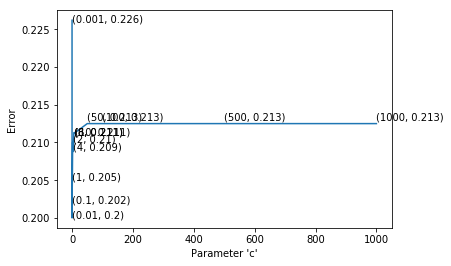

In [246]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["C"])
    
plot.plot(parameter, np.round(error, 4))
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plot.annotate(xy,xy)

plot.show()

#### Random Search

In [258]:
n = list(np.random.normal(loc=0.01, scale=0.001, size = 500))  #taking 500 numbers which are distributed normally with mean = 0.01
                                                            #and std-dev = 0.001

In [260]:
clf = LogisticRegression()

hyper_parameters2 = {'C': n}

bestCV_random = RandomizedSearchCV(clf, hyper_parameters2, scoring = "accuracy", cv = 3)

bestCV_random.fit(train_glove, train_labels_glove)
print(bestCV_random.best_estimator_)

LogisticRegression(C=0.010864778999588785, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [261]:
best_random_parameter = bestCV_random.best_params_ 
best_random_parameter["C"]

0.010864778999588785

In [262]:
scoreRandomData = bestCV_random.grid_scores_

In [263]:
scoreRandomData

[mean: 0.79125, std: 0.02455, params: {'C': 0.008893654934541298},
 mean: 0.79250, std: 0.02546, params: {'C': 0.00902858084277098},
 mean: 0.79375, std: 0.02647, params: {'C': 0.010864778999588785},
 mean: 0.79250, std: 0.02546, params: {'C': 0.009228367537127741},
 mean: 0.79125, std: 0.02471, params: {'C': 0.011585912590822901},
 mean: 0.79250, std: 0.02580, params: {'C': 0.010835089892548291},
 mean: 0.79125, std: 0.02455, params: {'C': 0.008366099150893012},
 mean: 0.79000, std: 0.02406, params: {'C': 0.012758200295857164},
 mean: 0.79250, std: 0.02546, params: {'C': 0.009837696631520804},
 mean: 0.79125, std: 0.02471, params: {'C': 0.010230751131592289}]

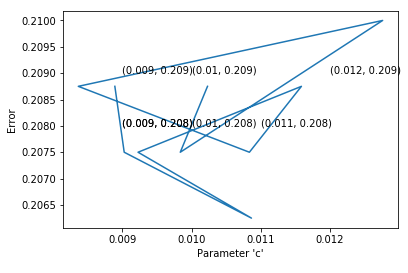

In [264]:
error2 = []
parameter2 = []
for i in range(len(scoreRandomData)):
    error2.append(1 - scoreRandomData[i][1])
    parameter2.append(scoreRandomData[i][0]["C"])  

plot.plot(parameter2, error2)
plot.xlabel("Parameter 'c'")
plot.ylabel("Error")

error3 = []
for e in error2:
    error3.append(np.round(e,3))
    
parameter3 = []
for p in parameter2:
    parameter3.append(np.round(p,3))

for xy in zip(parameter3, error3):
        plot.annotate(xy,xy)

plot.show()

In [265]:
# We are taking our hyper-parameter λ as the average of best λ computed from gridSearchCV and RandomSearchCV
FinalHP = (best_parameter["C"] + best_random_parameter["C"]) / 2
FinalHP

0.010432389499794394

### Task 3. Apply Logistic Regression using both L1 and L2 regularizations and report accuracy.

#### Implementing L2 Regularization

In [266]:
model = LogisticRegression(penalty="l2", C = FinalHP)

model.fit(train_glove, train_labels_glove)

prediction = model.predict(test_glove)

AccuracyScore = accuracy_score(test_labels_glove, prediction) * 100

print("Accuracy score on L2 regularization = "+str(AccuracyScore)+"%")

Accuracy score on L2 regularization = 79.0%


In [267]:
Precision = precision_score(test_labels_glove, prediction)
print("Precision Score on L2 regularization = "+str(Precision))

Precision Score on L2 regularization = 0.8461538461538461


In [268]:
Recall = recall_score(test_labels_glove, prediction)
print("Recall Score on L2 regularization = "+str(Recall))

Recall Score on L2 regularization = 0.7333333333333333


In [269]:
ConfusionMatrix = confusion_matrix(test_labels_glove, prediction)
print("Confusion Matrix on L2 regularization \n= "+str(ConfusionMatrix))

Confusion Matrix on L2 regularization 
= [[81 14]
 [28 77]]


In [270]:
tn, fp, fn, tp = confusion_matrix(test_labels_glove, prediction).ravel()
tn, fp, fn, tp

(81, 14, 28, 77)

#### Implementing L1 Regularization

In [273]:
model2 = LogisticRegression(penalty="l1", C = FinalHP)

model2.fit(train_glove, train_labels_glove)

prediction2 = model2.predict(test_glove)

AccuracyScore2 = accuracy_score(test_labels_glove, prediction2) * 100

print("Accuracy score on L1 regularization = "+str(AccuracyScore2)+"%")

Accuracy score on L1 regularization = 67.5%


In [274]:
Precision = precision_score(test_labels_glove, prediction2)
print("Precision Score on L1 regularization = "+str(Precision))

Precision Score on L1 regularization = 0.7222222222222222


In [275]:
Recall = recall_score(test_labels_glove, prediction2)
print("Recall Score on L1 regularization = "+str(Recall))

Recall Score on L1 regularization = 0.6190476190476191


In [276]:
ConfusionMatrix = confusion_matrix(test_labels_glove, prediction2)
print("Confusion Matrix on L1 regularization \n= "+str(ConfusionMatrix))

Confusion Matrix on L1 regularization 
= [[70 25]
 [40 65]]


In [277]:
tn, fp, fn, tp = confusion_matrix(test_labels_glove, prediction2).ravel()
tn, fp, fn, tp

(70, 25, 40, 65)

### Task 4. Use L1 regularization for different values of λ and report error and sparsity for each value of λ.

In [278]:
model3 = LogisticRegression(penalty="l1", C = 1000)

model3.fit(train_glove, train_labels_glove)

accuracyScore_10000 = model3.score(test_glove, test_labels_glove)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.001 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.001 = "+str(error))

Number of non-zero for λ value of 0.001 = 100
Error for λ value of 0.001 = 0.22999999999999998


In [279]:
model3 = LogisticRegression(penalty="l1", C = 100)

model3.fit(train_glove, train_labels_glove)

accuracyScore_10000 = model3.score(test_glove, test_labels_glove)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 0.01 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 0.01 = "+str(error))

Number of non-zero for λ value of 0.01 = 100
Error for λ value of 0.01 = 0.22999999999999998


In [280]:
model3 = LogisticRegression(penalty="l1", C = 1)

model3.fit(train_glove, train_labels_glove)

accuracyScore_10000 = model3.score(test_glove, test_labels_glove)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 1 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 1 = "+str(error))

Number of non-zero for λ value of 1 = 92
Error for λ value of 1 = 0.21999999999999997


In [281]:
model3 = LogisticRegression(penalty="l1", C = 10**-2)

model3.fit(train_glove, train_labels_glove)

accuracyScore_10000 = model3.score(test_glove, test_labels_glove)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 100 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 100 = "+str(error))

Number of non-zero for λ value of 100 = 2
Error for λ value of 100 = 0.32499999999999996


In [282]:
model3 = LogisticRegression(penalty="l1", C = 10**-4)

model3.fit(train_glove, train_labels_glove)

accuracyScore_10000 = model3.score(test_glove, test_labels_glove)

error = 1 - accuracyScore_10000

weightVector = model3.coef_

print("Number of non-zero for λ value of 10000 = "+str(np.count_nonzero(weightVector)))

print("Error for λ value of 10000 = "+str(error))

Number of non-zero for λ value of 10000 = 0
Error for λ value of 10000 = 0.525


### Task 5. Check for multi-collinearity of features and find top-10 most important features

In [283]:
# computing weight vector prior to adding noise in out data
model4 = LogisticRegression(penalty="l2", C = FinalHP)

model4.fit(train_glove, train_labels_glove)

weightVector1 = model4.coef_

In [284]:
noise = np.random.normal(loc=0.1, scale=0.1) # generating random positive number from normal distribution
noise_matrix = np.full((800, 100), noise) # generating matrix of size 4000 * 300 where every number in matrix is 'n' 
dataWithNoise_glove = noise_matrix + train_glove # adding noise to training data fro pertubation test

print(noise)
print(dataWithNoise_glove.shape)

0.04490121809728769
(800, 100)


In [285]:
# computing weight vector after adding noise in out data
model5 = LogisticRegression(penalty="l2", C = FinalHP)

model5.fit(dataWithNoise_glove, train_labels_glove)

weightVector2 = model5.coef_

In [286]:
differenceWeights = weightVector1 - weightVector2
differenceWeights.ravel()

array([ 4.23497834e-04,  2.89410219e-04,  3.25740221e-04,  4.29228648e-04,
        1.29199851e-04,  4.13238064e-04,  1.04042606e-04,  4.40570008e-04,
        3.74213476e-04, -2.34256914e-04,  2.38465597e-04,  3.42048111e-04,
        1.81592466e-04, -8.70773117e-06,  4.95984444e-04,  2.35376161e-04,
       -2.25085153e-04, -4.97572930e-05,  4.97980468e-04,  4.66802311e-04,
        5.24820587e-04, -2.03303600e-05,  3.48937061e-04,  3.46031406e-04,
       -2.16840855e-04,  3.03657060e-04,  2.83432580e-04,  1.67697936e-04,
        3.11069402e-04,  1.19079433e-04,  5.04643291e-04,  5.63305232e-04,
        3.32103226e-04, -4.26387743e-05,  2.65642812e-04,  3.00432122e-04,
        4.05883323e-04,  4.93371338e-04,  5.99841619e-04,  5.31515245e-04,
        2.05598990e-04,  3.87127227e-04,  8.49285958e-05,  1.93436503e-04,
        3.16120104e-04,  4.90627566e-04,  5.89163058e-04,  3.25872726e-04,
        2.03056121e-04,  1.03232189e-04,  5.53790632e-04, -5.77459757e-05,
        1.91736610e-04,  

**Here, as you can see that the differnce in the weight vectors prior and after adding noise is high. It means that features are collinear, hence we cannot use weight vectors as feature importance. Since glove generates vectors for words which are dependent on each other owing to their similarity of preserving sementic meaning between similar words. Therefore, features in glove are collinear similar to w2v**

# Summary

## 1) Average W2V

#### 1.1) Best Value of hyper-parameter(C) from Grid Search: 1000
#### 1.2) Best Value of hyper-parameter(C) from Random Search: 584.2338
#### 1.3) Accuracy of Logistic Regression on L2 Regularization: 83.6%
#### 1.4) Accuracy of Logistic Regression on L1 Regularization: 83.2%
#### 1.5) L1 regularization for different values of λ and report error and sparsity for each value of λ
#### 1.5.1) Number of non-zero for λ value of  0.0001= 400
####           Error for λ value of  0.0001= 0.169
#### 1.5.2) Number of non-zero for λ value of 0.001 = 400
####           Error for λ value of 0.001 = 0.171
#### 1.5.3) Number of non-zero for λ value of 0.1 = 230
####           Error for λ value of 0.1 = 0.1800
#### 1.5.4) Number of non-zero for λ value of 1000 = 0
####           Error for λ value of 1000 = 0.498
#### 1.5.5) Number of non-zero for λ value of 10000 = 0
####           Error for λ value of 10000 = 0.498


## 2) TFIDF-W2V

#### 2.1) Best Value of hyper-parameter(C) from Grid Search: 100
#### 2.2) Best Value of hyper-parameter(C) from Random Search:  107.5692
#### 2.3) Accuracy of Logistic Regression on L2 Regularization: 80.7%
#### 2.4) Accuracy of Logistic Regression on L1 Regularization: 80.7%
#### 2.5) L1 regularization for different values of λ and report error and sparsity for each value of λ
#### 2.5.1) Number of non-zero for λ value of 0.001 = 300
####           Error for λ value of 0.001 = 0.18799
#### 2.5.2) Number of non-zero for λ value of 0.01 = 292
####           Error for λ value of 0.01 = 0.19099
#### 2.5.3) Number of non-zero for λ value of 1 = 85
####           Error for λ value of 1 = 0.21799
#### 2.5.4) Number of non-zero for λ value of 1000 = 0
####           Error for λ value of 1000 = 0.498


## 3) GLoVe(Pre-trained)

#### 3.1) Best Value of hyper-parameter(C) from Grid Search: 0.01
#### 3.2) Best Value of hyper-parameter(C) from Random Search: 0.0108
#### 3.3) Accuracy of Logistic Regression on L2 Regularization: 79.0%
#### 3.4) Accuracy of Logistic Regression on L1 Regularization: 67.5%
#### 3.5) L1 regularization for different values of λ and report error and sparsity for each value of λ
#### 3.5.1) Number of non-zero for λ value of 0.001 = 100
####           Error for λ value of  = 0.2299
#### 3.5.2) Number of non-zero for λ value of  = 100
####           Error for λ value of 0.01 = 0.2299
#### 3.5.3) Number of non-zero for λ value of 1 = 92
####           Error for λ value of 1 = 0.21999
#### 3.5.4) Number of non-zero for λ value of 100 = 2
####           Error for λ value of 100 = 0.324
#### 3.5.5) Number of non-zero for λ value of 10000 = 0
####           Error for λ value of 10000 = 0.525